In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets

# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy import stats

In [2]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = eps = np.random.normal(0 ,1 , 100)

In [3]:
y_np = 2 + 2*x + 3*(x**2) + 2.5*(x**3) + eps


In [20]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]

In [ ]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

In [4]:
# Get predictor count
k = np.arange(1, len(X.columns)+1)

# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))

# Plot best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

# Select best subset
coefs_r2 = [(max_adjr2(m)[1].rsquared_adj, max_adjr2(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(max(coefs_r2)[1]))


# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))

# Get best BIC
bic = [min_bic(m)[1].bic for m in model_subsets]

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

# Select best subset
coefs_bic = [(min_bic(m)[1].bic, min_bic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_bic)[1]))


# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))

# Get best AIC
aic = [min_aic(m)[1].aic for m in model_subsets]

sns.lineplot(x=k, y=aic)
plt.xlabel('k')
plt.ylabel('AIC')
plt.show()

# Select best subset
coefs_aic = [(min_aic(m)[1].aic, min_aic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_aic)[1]))

NameError: name 'X' is not defined

In [ ]:
def forward_stepwise(X, y, scorer='ssr', results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds}).drop(0)
    
    # Get score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = '{} ~ {}'.format(y.columns[0], '+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r    += [(model, [p]+p_used)]
    
    # Choose predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 
                        
    new_results = results + [best_score]
    # Recursive call to self
    return forward_stepwise(X, y, scorer, new_results)

In [30]:
def backward_stepwise(X, y, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise(X, y, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise(X, y, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise(X, y, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise(X, y, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise(X, y, scorer, new_results)


def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    ax = sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))

In [8]:
def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=False, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

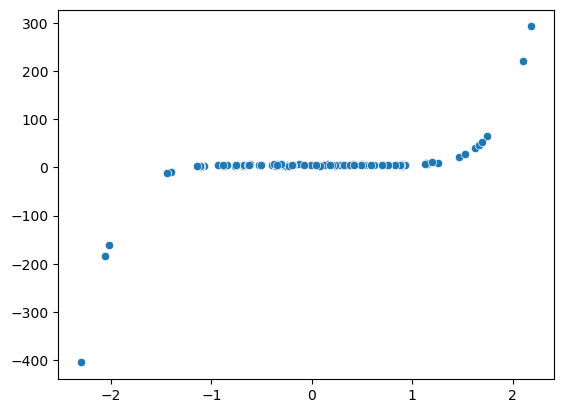

In [44]:
np.random.seed(1)
x   = np.random.normal(0, 1, 100)
eps = np.random.normal(0 ,1 , 100)

y_np = 5 + 1.2*(x**7) + eps

sns.scatterplot(x=x, y=y_np);

In [48]:
X = pd.DataFrame({'X': x,
                  'X2': x**2,
                  'X3': x**3,
                  'X4': x**4,
                  'X5': x**5,
                  'X6': x**6,
                  'X7': x**7,
                  'X8': x**8,
                  'X9': x**9,
                  'X10': x**10})
y = pd.DataFrame({'y': y_np})

In [50]:
def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]


def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


# Intended API
# ----------------------------------------------

def best_subset(X, y, scorer='ssr'):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))

    # Select best in each subset using chosen scorer
    if scorer == 'ssr':
        # Get best rss score for each subset
        return [min_rss(m) for m in model_subsets]
    elif scorer == 'rsquared_adj':
        # Get best rss score for each subset
        return [max_adjr2(m) for m in model_subsets]       
    elif scorer == 'bic':
        # Get best rss score for each subset
        return [min_bic(m) for m in model_subsets]
    elif scorer == 'aic':
        # Get best rss score for each subset
        return [min_aic(m) for m in model_subsets]

    
def cross_val(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return (MSEs, formula)

In [52]:
# get all model results
best_subset_models = best_subset(X, y, scorer='bic')

Best subset selected: k = 1/10, done
Best subset selected: k = 2/10, done
Best subset selected: k = 3/10, done
Best subset selected: k = 4/10, done
Best subset selected: k = 5/10, done
Best subset selected: k = 6/10, done
Best subset selected: k = 7/10, done
Best subset selected: k = 8/10, done
Best subset selected: k = 9/10, done
Best subset selected: k = 10/10, done


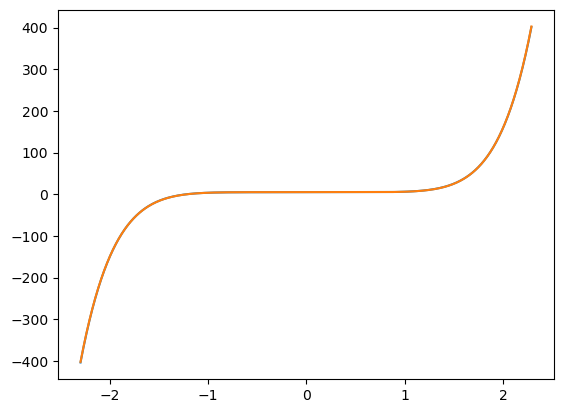

In [56]:
x = np.arange(-2.3, 2.3, 0.01)
sns.lineplot(x=x, y=5 + 1.2*(x**7))
sns.lineplot(x=x, y=5.27 - 0.32*(x**2) + 0.02*(x**6) + 1.20*(x**7));

In [58]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, fit_intercept=True, normalize=True, max_iter=1000000).fit(X_train, y_train)

        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test['y'])]
    return MSEs

In [78]:
college_df = pd.read_csv('College.csv')

# 8(b) label rows by college
college_df = college_df.set_index(['Unnamed: 0'], append=True, verify_integrity=True)
college_df.rename_axis([None, 'College'], inplace=True)

# Get dummimies
college_df = pd.get_dummies(college_df).drop('Private_No', axis=1)

# Convert to floats
college_df = college_df.astype(np.float64)

# Remove fullstops from col names
college_df = college_df.rename(index=str, columns={"F.Undergrad": "F_Undergrad", 
                                                   "P.Undergrad": "P_Undergrad",
                                                   "S.F.Ratio": "S_F_Ratio",
                                                   "perc.alumni": "perc_alumni",
                                                   "Grad.Rate": "Grad_Rate",
                                                   "Room.Board": "Room_Board"})

# Assign train and test sets
np.random.seed(1)
train = np.random.rand(len(college_df)) < 0.5
response   = 'Apps'
X_train = college_df[train].drop(response, axis=1)
X_test  = college_df[~train].drop(response, axis=1)
y_train = college_df[train][response]
y_test  = college_df[~train][response]


display(X_train.head())

,,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
,College,,,,,,,,,,,,,,,,,
0,Abilene Christian University,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0,1.0
2,Adrian College,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0,1.0
3,Agnes Scott College,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0,1.0
4,Alaska Pacific University,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0,1.0
5,Albertson College,479.0,158.0,38.0,62.0,678.0,41.0,13500.0,3335.0,500.0,675.0,67.0,73.0,9.4,11.0,9727.0,55.0,1.0


In [80]:
# OLS
# Use all available features
f = '{} ~ {}'.format(response, '+'.join(X_train.columns))

# Fit model
model = smf.ols(formula=f, data=pd.concat([X_train, y_train], axis=1)).fit()
y_hat = model.predict(X_test)
print('RMSE: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE: 1229.1326212399865


In [90]:
def pcr_cv(seed, cv_folds):
    """Perform Principle Component Regression evaluated with
    k-fold cross validation"""

    # Select components with cross-validation
    # ---------------------------------------
    # Load data
    X = college_df[train].drop(response, axis=1)
    y = college_df[train][response]
    
    # Get all principle components
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    MSEs = []
    for m in range(M):
        model = LinearRegression()
        cv    = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        cv10  = cross_val_score(model, X_reduced[:, 0:m+1], y, cv=cv, scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv10))]
        
    df = pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)})
    ax = sns.lineplot(x='principal components count', y='RMSE_CV', data=df)
    plt.show();
    #ax.axes.set_ylim(100000, 140000)

    # Make Test predictions
    # ---------------------------------------
    
    # Get optimal number of compoenents from cv results
    m = df[df['RMSE_CV'] == df['RMSE_CV'].min()]['principal components count'].iloc[0]
    
    # Get all principle components across train and test values for X
    X_reduced = pca.fit_transform(scale(college_df.drop(response, axis=1)))
    
    # Fit model on TRAINING subset of PCs
    model = LinearRegression()
    model.fit(X_reduced[train][:, 0:m+1], y_train)
    # Predict using TEST subset of PCs
    y_hat = model.predict(X_reduced[~train][:, 0:m+1])
    
    # Show results for optimal number of components
    best_df = df[df['RMSE_CV'] == df['RMSE_CV'].min()]
    best_df['RSME_Test'] = np.sqrt(mse(y_hat, y_test))
    display(best_df)
    
    print(model.score(X_reduced[~train][:, 0:m+1], y_test))
    

interact(pcr_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

In [92]:
from sklearn.cross_decomposition import PLSRegression

def pls_cv(seed, cv_folds):
    """Perform Partial Least Squares Regression evaluated with
    k-fold cross validation"""

    # Select components with cross-validation
    # ---------------------------------------
    # Load test data
    X_train = np.array(college_df[train].drop(response, axis=1))
    y_train = np.array(college_df[train][response])   
    X_test  = np.array(college_df[~train].drop(response, axis=1))
    y_test  = np.array(college_df[~train][response])
    
    # Get cv MSE for cumulative components
    M = X_train.shape[1]
    MSEs = []
    for m in range(M):
        cv      = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        results = cross_val_score(PLSRegression(n_components=m+1, scale=True, max_iter=10000), 
                                  X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        MSEs   += [np.mean(np.abs(results))]
        
    df = pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)})
    ax = sns.lineplot(x='principal components count', y='RMSE_CV', data=df)
    plt.show();
    
    # Make Test predictions
    # ---------------------------------------
    # Get optimal number of components from cv results
    m = df[df['RMSE_CV'] == df['RMSE_CV'].min()]['principal components count'].iloc[0]
    print(m)

    # Fit model on TRAINING subset of PCs
    model = PLSRegression(n_components=m, scale=True, max_iter=10000).fit(X_train, y_train)
    # Predict using TEST subset of PCs
    X_test_r, y_test_r = model.transform(X_test, y_test)
    y_hat = model.predict(X_test)
    
    # Show results for optimal number of components
    best_df = df[df['RMSE_CV'] == df['RMSE_CV'].min()]
    best_df['RSME_Test'] = np.sqrt(mse(y_hat.T[0], y_test))
    display(best_df)

    
interact(pls_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

In [94]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

X_train = college_df[train].drop(response, axis=1)
X_test  = college_df[~train].drop(response, axis=1)
y_train = pd.DataFrame({'Apps': college_df[train][response]})
y_test  = np.array(college_df[~train][response])

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')

selector = selector.fit(X_train, y_train)

y_hat = selector.predict(X_test)
print('RMSE: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE: 115798.3233799448


In [96]:
def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

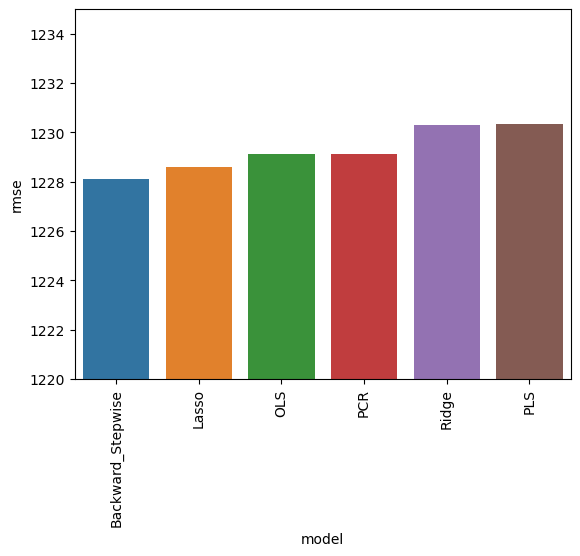

,model,rmse
0,Backward_Stepwise,1228.10
1,Lasso,1228.58
2,OLS,1229.13
3,PCR,1229.13
4,Ridge,1230.29
5,PLS,1230.36


In [98]:
models = ['Backward_Stepwise', 'Lasso', 'OLS', 'PCR', 'Ridge', 'PLS']
rmses  = [1228.10, 1228.58, 1229.13, 1229.13, 1230.29, 1230.36]
results = pd.DataFrame({'model': models, 'rmse': rmses})

ax = sns.barplot(x='model', y='rmse', data=results)
ax.set_ylim([1220,1235])
plt.xticks(rotation=90)
plt.show();

display(results)

In [100]:
college_df['Apps'].mean()

3001.6383526383524